In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import math

#pd.set_option('display.max_colwidth', 1)

## Data Prep

In [10]:
df = pd.read_excel('Data/Revised Main.xlsx')
#temp = pd.read_excel('Clinical Trial Data Pull.xlsx',sheet_name='Sheet3')

In [11]:
df.shape

(56, 2)

In [ ]:
df.isna().sum()

In [ ]:
df = df.drop(columns=['Unnamed: 34','Unnamed: 35'],axis=1)

In [ ]:
df = df.drop_duplicates(subset='NCT Number')
df['Locations'] = df['Locations'].fillna('Not Provided')

In [ ]:
df['New end date'][df['New end date']=='Not provided']=pd.NaT

In [ ]:
df['New Start date'] = pd.to_datetime(df['New Start date'])
df['New end date'] = pd.to_datetime(df['New end date'])

In [ ]:
df['Study Duration'] = df['New end date'][(df['End date']!=0)&(df['End date'].dt.year!='1900')] - df['New Start date'][df['Start Day']!=0 &(df['Start Day'].dt.year!='1900')]

In [ ]:
#!python -m pip install pycountry
import pycountry

cntry = []

for country in pycountry.countries:
    cntry.append(country.name)
    
cntry.remove('United States')

df['Outside US'] = df['Locations'].str.contains('|'.join(cntry))
df['US'] = df['Locations'].str.contains('United States')

df['Both'] = df['US'] & df['Outside US']

df['Country'] = ''

df['Country'] = np.where(df['Locations'].str.contains('|'.join(cntry)),'Outside US',df['Country'])
df['Country'] = np.where(df['Locations'].str.contains('United States'),'US',df['Country'])
df['Country'] = np.where((df['US'] & df['Outside US']),'Both US and outside',df['Country'])
df['Country'] = np.where(df['Locations']=='Not Provided','Not Provided',df['Country'])
df['Country'] = np.where(df['Locations']==' ','Not Provided',df['Country'])
df['Country'][(~df.Country.isin(['US','Outside US','Both US and outside','Not Provided']))] = 'Not Provided'

In [ ]:
df['Age Category'] = ''

df['Age Category'] = np.where(df['Children']=='Yes','Child',df['Age Category'])
df['Age Category'] = np.where(df['Adult']=='Yes','Adult',df['Age Category'])
df['Age Category'] = np.where(df['Older Adult']=='Yes','Older Adult',df['Age Category'])
df['Age Category'] = np.where((df['Older Adult']=='Yes')&(df['Adult']=='Yes'),'Adults, Older Adult',df['Age Category'])


df['Age Category'] = np.where((df['Older Adult']=='No')&(df['Adult']=='Yes')&(df['Children']=='Yes'),'Child, Adult',df['Age Category'])
df['Age Category'] = np.where((df['Older Adult']=='Yes')&(df['Adult']=='Yes')&(df['Children']=='No'),'Adult, Older Adult',df['Age Category'])
df['Age Category'] = np.where((df['Older Adult']=='Yes')&(df['Adult']=='No')&(df['Children']=='Yes'),'Child, Older Adult',df['Age Category'])
df['Age Category'] = np.where((df['Older Adult']=='Yes')&(df['Adult']=='Yes')&(df['Children']=='Yes'),'Child, Adult, Older Adult',df['Age Category'])

In [ ]:
df['location_center']= df['locations'].str.contains('Center')
df['location_hospital'] = df['locations'].str.contains('Hospital')
df['location_institute'] = df['locations'].str.contains('Institute')
df['location_university'] = df['locations'].str.contains('University|College|University Hospital|School')
#df[['Locations','Location - Center','Location - Hospital','Location - University']]

In [ ]:
df['Study Type'][~df['Study Type'].isin(['Interventional','Observational'])] = 'Expanded Access'

In [ ]:
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.lower()

df.rename(columns={'start_date':'old_start_date','completion_date':'old_completion_date',
                   'new_start_date':'start_date','new_end_date':'completion_date',
                   'sponsor/collaborators':'sponsors_collaborators'},inplace=True)

In [ ]:
df['study_designs'].fillna('Not Provided')

df['randomized_study'] = 'Not Provided'
df['randomized_study'] = np.where((df['study_designs'].str.find('Randomized')>0)|(df['study_designs'].str.find('Random')>0),'Randomized',df['randomized_study'])
df['randomized_study'] = np.where(df['study_designs'].str.find('Non-Randomized')>0,'Non Randomized',df['randomized_study'])

In [ ]:
df['study_model'] = 'Not Provided'
df['study_model'] = np.where(df['study_designs'].str.find('Intervention Model')>0,'Interventional',df['study_model'])
df['study_model'] = np.where(df['study_designs'].str.find('Observational Model')>0,'Observational',df['study_model'])

In [ ]:
df['time_category_retrospective'] = ''
df['time_category_prospective'] = ''
df['time_category_other'] = ''
df['time_category_longitudinal'] = ''
df['time_category_cross_sectional'] = ''

df['time_category_retrospective'] = np.where(df['study_designs'].str.find('Time Perspective: Retrospective')>0,True,False)
df['time_category_prospective'] = np.where(df['study_designs'].str.find('Time Perspective: Prospective')>0,True,False)
df['time_category_other'] = np.where(df['study_designs'].str.find('Time Perspective: Other')>0,True,False)
df['time_category_longitudinal'] = np.where(df['study_designs'].str.find('Time Perspective: Longitudinal')>0,True,False)
df['time_category_cross_sectional'] = np.where(df['study_designs'].str.find('Time Perspective: Cross-Sectional')>0,True,False)

df['time_category'] = 'Not Provided'

df['time_category'] = np.where(df['time_category_retrospective'],'Retrospective',df['time_category'])
df['time_category'] = np.where(df['time_category_prospective'],'Prospective',df['time_category'])
df['time_category'] = np.where(df['time_category_other'],'Other',df['time_category'])
df['time_category'] = np.where(df['time_category_longitudinal'],'Longitduinal',df['time_category'])
df['time_category'] = np.where(df['time_category_cross_sectional'],'Cross_Sectional',df['time_category'])

In [ ]:
df['study_designs'].fillna('Not Provided')

df['masking'] = 'Not Provided'
df['masking'] = np.where(df['study_designs'].str.find('Masking: None')>0,'None',df['masking'])
df['masking'] = np.where(df['study_designs'].str.find('Masking: Single')>0,'Single',df['masking'])
df['masking'] = np.where(df['study_designs'].str.find('Masking: Double')>0,'Double',df['masking'])
df['masking'] = np.where(df['study_designs'].str.find('Masking: Triple')>0,'Triple',df['masking'])
df['masking'] = np.where(df['study_designs'].str.find('Masking: Quadruple')>0,'Quadruple',df['masking'])

In [ ]:
a = df['study_designs'].str.extract('(Primary Purpose: [a-zA-z\s\-]*)')#|(Masking: [A-Za-z\s\(\)]*)|(Time Perspective: [a-zA-z\s]*)')

df['primary_purpose'] = 'Not Provided'
for purpose in a[0].value_counts().index:
    df['primary_purpose'] = np.where((df['study_designs'].str.find(str(purpose))>0),purpose.split(':')[1].strip(),df['primary_purpose'])

In [ ]:
df['number_of_sponsors'] = df['sponsors_collaborators'].str.split('|').apply(lambda x: len(x))
df['number_of_locations'] = df['locations'].str.split('|').apply(lambda x: len(x))

In [ ]:
# b = {}
# for disease in df['conditions'].value_counts().index:
#     b['{}'.format(disease)] = (df['conditions'].str.find(disease)>=0).sum()

# import operator
# sorted_x = sorted(b.items(), key=operator.itemgetter(1),reverse=True)

# c = pd.DataFrame(sorted_x)

c = pd.read_csv('Disease_count.csv')
c.head(20)

In [ ]:
df['completion_date'] = pd.to_datetime(df['completion_date'])
df['start_date'] = pd.to_datetime(df['start_date'])

# df['completion_date'] = pd.to_datetime(np.where(df['completion_date'].dt.year!=1800,df['completion_date'],pd.NaT))
# df['start_date'] = pd.to_datetime(np.where(df['start_date'].dt.year!=1900,df['start_date'],pd.NaT))

df['study_duration'] = df['completion_date'] - df['start_date']

## Analysis

In [4]:
#df.to_csv('Data/Final Data.csv')
df = pd.read_csv('Data/Final Data.csv',index_col=0)

In [13]:
df.shape

(64698, 55)

In [2]:
df1 = pd.read_csv('Data/Final Data.csv',index_col=0)

In [5]:
df['completion_date'] = pd.to_datetime(df['completion_date'])
df['start_date'] = pd.to_datetime(df['start_date'])
df['last_update_posted'] = pd.to_datetime(df['last_update_posted'])


df['study_duration'] = df['completion_date']-df['start_date']
df['study_duration'][df['study_duration'].notnull()]  = (df['study_duration'][df['study_duration'].notnull()] / np.timedelta64(1, 'D')).astype(int)

C:\Users\Sarvesh Shah\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [ ]:
df['start_date'][df['status']=='Approved for marketing'] = df['old_start_date'][df['status']=='Approved for marketing']

In [ ]:
df['study_duration'].isna().sum()

In [ ]:
df.groupby(['primary_purpose','age_category'])[['nct_number']].agg({'count'}).unstack()

In [ ]:
# data = pd.concat([data,pd.get_dummies(data['status'],prefix='status')],axis=1)
# data = pd.concat([data,pd.get_dummies(data['study_results'],prefix='study_results')],axis=1)
# data = pd.concat([data,pd.get_dummies(data['funded_bys'],prefix='funded_by')],axis=1)
# data = pd.concat([data,pd.get_dummies(data['randomized_study'],prefix='randomized_study')],axis=1)
# data = pd.concat([data,pd.get_dummies(data['masking'],prefix='masking')],axis=1)
# data = pd.concat([data,pd.get_dummies(data['primary_purpose'],prefix='primary_purpose')],axis=1)
# data = pd.concat([data,pd.get_dummies(data['gender'],prefix='gender')],axis=1)
# data = pd.concat([data,pd.get_dummies(data['age_category'],prefix='age')],axis=1)
# data = pd.concat([data,pd.get_dummies(data['study_designs'],prefix='study_designs')],axis=1)
# data = pd.concat([data,pd.get_dummies(data['study_type'],prefix='study_type')],axis=1)


#data = data.drop(columns=['status','study_results','funded_bys','masking','primary_purpose','gender','randomized_study','age_category','study_designs','study_type'])

In [ ]:
cols = ['drug',
 'biologic',
 'behavioral',
 'other',
 'procedure',
 'device',
 'genetic',
 'dietary',
 'radiation',
 'location_center',
 'location_hospital',
 'location_institute',
 'location_university',
 'time_category_retrospective',
 'time_category_prospective',
 'time_category_other',
 'time_category_longitudinal',
 'time_category_cross_sectional']

for col in cols:
    #print(col)
    df['{}'.format(col)] = df['{}'.format(col)].astype(int)
    
#data['study_duration']  = (data['study_duration'] / np.timedelta64(1, 'D')).astype(int)

p = ['drug',
 'biologic',
 'behavioral',
 'other',
 'procedure',
 'device',
 'genetic',
 'dietary',
 'radiation', 
 'outside_us',
 'us',
 'both',
 'location_center',
 'location_hospital',
 'location_institute',
 'location_university',
 'time_category_retrospective',
 'time_category_prospective',
 'time_category_other',
 'time_category_longitudinal',
 'time_category_cross_sectional']

for q in p:
    df['{}'.format(q)] = np.where(df['{}'.format(q)]=='TRUE',1,df['{}'.format(q)])
    df['{}'.format(q)] = np.where(df['{}'.format(q)]=='FALSE',0,df['{}'.format(q)])
    df['{}'.format(q)] = np.where(df['{}'.format(q)]=='True',1,df['{}'.format(q)])
    df['{}'.format(q)] = np.where(df['{}'.format(q)]=='False',0,df['{}'.format(q)])
    df['{}'.format(q)] = np.where(df['{}'.format(q)]=='Yes',1,df['{}'.format(q)])
    df['{}'.format(q)] = np.where(df['{}'.format(q)]=='No',0,df['{}'.format(q)])

for q in p:
    print(q)
    df['{}'.format(q)] = df['{}'.format(q)].astype(int)
    
    

In [22]:
a = df[df['status']=='Approved for marketing'][['nct_number','start_date','last_update_posted','drug', 'biologic', 'behavioral', 'other', 'procedure', 'device', 'genetic', 'dietary', 'radiation']]
a['difference'] = a['last_update_posted'] - a['start_date']

a['difference'] = (a['difference'] / np.timedelta64(1, 'D')).astype(int)

In [23]:
a.sort_values(by='difference')

,nct_number,start_date,last_update_posted,drug,biologic,behavioral,other,procedure,device,genetic,dietary,radiation,difference
49030,NCT03955679,2019-05-20,2019-06-05,0,0,0,0,0,0,1,0,0,16
48956,NCT03177005,2017-06-06,2017-07-31,0,1,0,0,0,0,0,0,0,55
48927,NCT03025867,2017-01-20,2017-04-17,1,0,0,0,0,0,0,0,0,87
47968,NCT01683110,2012-09-11,2013-01-16,1,0,0,0,0,0,0,0,0,127
48336,NCT02136511,2014-05-13,2014-10-28,1,0,0,0,0,0,0,0,0,168
46875,NCT00786058,2008-11-05,2009-06-15,1,0,0,0,0,0,0,0,0,222
48937,NCT03079687,2017-03-14,2017-10-25,1,0,0,0,0,0,0,0,0,225
47686,NCT01381289,2011-06-27,2012-02-09,1,0,0,0,0,0,0,0,0,227
46481,NCT00484991,2007-06-12,2008-04-15,1,0,0,0,0,0,0,0,0,308
48112,NCT01858103,2013-05-21,2014-04-02,1,0,0,0,0,0,0,0,0,316


In [ ]:
df[df['status']=='Approved for marketing']

In [ ]:
pd.DataFrame(df['outcome_measures'].value_counts()).to_csv('keywords.csv')

In [ ]:
df[(df['study_results']=='Has Results')&(df['status']=='Completed')]

In [ ]:
df.head()

In [ ]:
df['start_year'] = df['start_date'].dt.year

In [ ]:
df.groupby(['start_year'])[['enrollment']].mean().plot()

In [ ]:
plt.figure(figsize=(10,10*2.68))
df[df['gender']=='Male'].groupby(['start_year'])[['nct_number']].sum().plot()
df[df['gender']=='Female'].groupby(['start_year'])[['nct_number']].sum().plot()
df[df['gender']=='All'].groupby(['start_year'])[['nct_number']].sum().plot()



In [ ]:
plt.figure(figsize=(10,10*2.68))
df[df['gender']=='Male'].groupby(['start_year'])[['enrollment']].mean().plot()
df[df['gender']=='Female'].groupby(['start_year'])[['enrollment']].mean().plot()
df[df['gender']=='All'].groupby(['start_year'])[['enrollment']].mean().plot()



In [ ]:
df['gender'].value_counts()

In [ ]:
a = df[df['gender']!='All'].groupby(['start_year','age_category'])[['nct_number']].count().unstack()
# a['nc_count'] = a.nct_number.shift(-1)
# a['dif'] = (a['nc_count']-a['nct_number'])*100./a['nct_number']
a

In [ ]:
df[(df['age_category']=='Adult')].groupby(['start_year'])[['enrollment']].mean().plot()


In [ ]:
df[(df['age_category']=='Older Adult')&(df['nct_number']!='NCT02612688')&((df['nct_number']!='NCT03365050'))].groupby(['start_year'])[['enrollment']].mean()
#plt.ylim(0,1000)

In [ ]:
(-164.125000 + 444.745763)*100./164.125000

In [ ]:
df[(df['age_category']=='Older Adult')&(df['start_year']==2018)][['nct_number','enrollment']].sort_values(by='enrollment',ascending=False)

In [ ]:
df['sponsors_collaborators'].value_counts()

In [ ]:
df['funded_bys'].value_counts()

In [ ]:
df[df['funded_bys'].str.match('NIH')].groupby(['start_year','funded_bys'])[['nct_number']].count().unstack()['nct_number'][['NIH']].loc[[2000,2018]]
#df[df['funded_bys'].str.match('Industry')].groupby(['start_year','funded_bys'])[['nct_number']].count().unstack()['nct_number'][['Industry']].loc[[2000,2018]]
#df[df['funded_bys'].str.match('Other')].groupby(['start_year','funded_bys'])[['nct_number']].count().unstack()['nct_number'][['Other']].loc[[2000,2018]]
#df[df['funded_bys'].str.match('U.S. Fed')].groupby(['start_year','funded_bys'])[['nct_number']].count().unstack()['nct_number'][['U.S. Fed']].loc[[2000,2018]]

In [ ]:

plt.figure(figsize=(10*1.68,10))
plt.plot(df[df['funded_bys'].str.match('NIH')].groupby(['start_year','funded_bys'])[['nct_number']].count().unstack()['nct_number'][['NIH']],label='NIH',linewidth=2.5)
plt.plot(df[df['funded_bys'].str.match('Industry')].groupby(['start_year','funded_bys'])[['nct_number']].count().unstack()['nct_number'][['Industry']],label='Industry',linewidth=2.5)
plt.plot(df[df['funded_bys'].str.match('Other')].groupby(['start_year','funded_bys'])[['nct_number']].count().unstack()['nct_number'][['Other']],label='Other',linewidth=2.5)
plt.plot(df[df['funded_bys'].str.match('U.S. Fed')].groupby(['start_year','funded_bys'])[['nct_number']].count().unstack()['nct_number'][['U.S. Fed']],label='U.S. Fed',linewidth=2.5)


plt.legend(fontsize=20)
plt.xlabel('Start Year',fontsize=20)
plt.ylabel('No. of Studies',fontsize=20)
plt.title('Number of studies funded by funders over the years',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [ ]:
df.groupby(['study_type','funded_bys'])[['nct_number']].count().unstack()

In [ ]:
list(df)

### Successful Trials

In [6]:
dfs = df[(df['study_results']=='Has Results')&(df.study_designs.str.find('Single Group Assignment')<0)&((df['status']=='Completed')|(df['status']=='Approved for marketing'))&(df['randomized_study']=='Randomized')&(df['masking']!='None')]


dfns = df[~((df['study_results']=='Has Results')&(df.study_designs.str.find('Single Group Assignment')<0)&((df['status']=='Completed')|(df['status']=='Approved for marketing'))&(df['randomized_study']=='Randomized')&(df['masking']!='None'))]

In [ ]:
dfs.shape[0]/df.shape[0]
dfns.shape[0]/df.shape[0]

In [ ]:
dfs.masking.value_counts()

In [25]:
b = {}
for disease in dfs['conditions'].value_counts().index:
    b['{}'.format(disease)] = (dfs['conditions'].str.find(disease)>=0).sum()

import operator
sorted_x = sorted(b.items(), key=operator.itemgetter(1),reverse=True)

c = pd.DataFrame(sorted_x)

# c = pd.read_csv('Data/Disease_count.csv',index_col=0)
# c.head(20)
# c['per'] = c['1']*100/c['1'].sum()
# c

In [65]:
(df_rare['study_duration'][df_rare['study_duration']>0].mean()/365) #- df['study_duration'][df['study_duration']>0].mean()/365 )*100 / (df['study_duration'][df['study_duration']>0].mean()/365)

5.151104381720155

In [66]:
pd.DataFrame(df_rare['age_category'].value_counts()*100/df_rare['age_category'].value_counts().sum())

,age_category
"Adult, Older Adult",77.174440
"Child, Adult, Older Adult",10.811597
"Child, Adult",7.175410
Adult,2.424125
Older Adult,1.415689
Child,0.998739


In [68]:
df_rare['enrollment'][df_rare['enrollment']<1500].mean()

106.77139949109414

In [ ]:
63.528010+7.270560-100

In [69]:
pd.DataFrame(df_rare['number_of_locations'].value_counts()*100/df_rare['number_of_locations'].value_counts().sum()).head()

,number_of_locations
1,62.843014
2,7.097838
3,3.548919
4,2.307767
5,1.948996


In [70]:
temp = pd.DataFrame(df_rare['funded_bys'].value_counts()*100/df_rare['funded_bys'].value_counts().sum()).reset_index()
temp['a'] = temp['index'].str.split('|').apply(lambda x: len(x))
temp.groupby('a')[['funded_bys']].sum()

,funded_bys
a,
1,69.698439
2,29.176767
3,1.115097
4,0.009696


In [71]:
pd.DataFrame(df_rare['gender'].value_counts()*100/df_rare['gender'].value_counts().sum()).head()

,gender
All,94.787420
Female,5.096098
Male,0.116482


In [72]:
pd.DataFrame(df_rare['randomized_study'].value_counts()*100/df_rare['randomized_study'].value_counts().sum()).head()

,randomized_study
Not Provided,60.806749
Non Randomized,19.848735
Randomized,19.344517


In [73]:
pd.DataFrame(df_rare['masking'].value_counts()*100/df_rare['masking'].value_counts().sum()).head()

,masking
None,79.559779
Not Provided,16.038010
Double,1.318724
Quadruple,1.270241
Single,1.076311


In [74]:
pd.DataFrame(df_rare['study_results'].value_counts()*100/df_rare['study_results'].value_counts().sum()).head()

,study_results
No Results Available,84.262581
Has Results,15.737419


In [48]:
pd.DataFrame(df_nrare['country'].value_counts()*100/df_nrare['country'].value_counts().sum()).head()

,country
Outside US,43.652513
US,32.084055
Both US and outside,14.818024
Not Provided,9.445407


In [49]:
pd.DataFrame(df_nrare['status'].value_counts()*100/df_nrare['status'].value_counts().sum()).head()

,status
Completed,42.201040
Recruiting,21.707106
"Active, not recruiting",9.943674
Terminated,9.575390
Unknown status,7.279029


In [75]:
pd.DataFrame(df_rare['number_of_sponsors'].value_counts()*100/df_rare['number_of_sponsors'].value_counts().sum()).head()

,number_of_sponsors
1,49.403665
2,37.486667
3,8.125667
4,2.472607
5,1.076311


In [454]:
df_rare[df_rare['funded_bys'].str.match('NIH')][['nct_number']].count()

nct_number    1150
dtype: int64

In [76]:
#display(pd.DataFrame(df_rare['funded_bys'].value_counts()*100/df_rare['funded_bys'].value_counts().sum()))
display(pd.DataFrame(df_rare['funded_bys'].value_counts()*100/df_rare['funded_bys'].value_counts().sum()))

,funded_bys
Other,35.925531
Industry,26.073887
Other|NIH,13.836905
Other|Industry,12.605449
NIH,7.689324
Industry|Other,1.997479
Other|NIH|Industry,0.630272
NIH|Other,0.339377
Other|Industry|NIH,0.329681
Industry|NIH,0.164840


In [ ]:

plt.figure(figsize=(10*1.68,10))
plt.plot(dfs[dfs['funded_bys'].str.match('NIH')].groupby(['start_year','funded_bys'])[['nct_number']].count().unstack()['nct_number'][['NIH']],label='NIH',linewidth=2.5)
plt.plot(dfs[dfs['funded_bys'].str.match('Industry')].groupby(['start_year','funded_bys'])[['nct_number']].count().unstack()['nct_number'][['Industry']],label='Industry',linewidth=2.5)
plt.plot(dfs[dfs['funded_bys'].str.match('Other')].groupby(['start_year','funded_bys'])[['nct_number']].count().unstack()['nct_number'][['Other']],label='Other',linewidth=2.5)
plt.plot(dfs[dfs['funded_bys'].str.match('U.S. Fed')].groupby(['start_year','funded_bys'])[['nct_number']].count().unstack()['nct_number'][['U.S. Fed']],label='U.S. Fed',linewidth=2.5)


plt.legend(fontsize=20)
plt.xlabel('Start Year',fontsize=20)
plt.ylabel('No. of Studies',fontsize=20)
plt.title('Number of studies funded by funders over the years',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [10]:
dfs['successful'] = 1
dfns['successful'] = 0

C:\Users\Sarvesh Shah\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Sarvesh Shah\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
list(df)

['nct_number',
 'title',
 'acronym',
 'status',
 'study_results',
 'conditions',
 'interventions',
 'drug',
 'biologic',
 'behavioral',
 'other',
 'procedure',
 'device',
 'genetic',
 'dietary',
 'radiation',
 'outcome_measures',
 'sponsors_collaborators',
 'gender',
 'age',
 'children',
 'adult',
 'older_adult',
 'enrollment',
 'funded_bys',
 'study_type',
 'study_designs',
 'old_start_date',
 'start_date',
 'old_completion_date',
 'completion_date',
 'study_duration',
 'last_update_posted',
 'locations',
 'outside_us',
 'us',
 'both',
 'country',
 'age_category',
 'location_center',
 'location_hospital',
 'location_institute',
 'location_university',
 'randomized_study',
 'intervention_model',
 'time_category_retrospective',
 'time_category_prospective',
 'time_category_other',
 'time_category_longitudinal',
 'time_category_cross_sectional',
 'time_category',
 'masking',
 'primary_purpose',
 'number_of_sponsors',
 'number_of_locations']

In [14]:
pd.DataFrame(dfs['sponsors_collaborators'].value_counts()*100/dfs['sponsors_collaborators'].value_counts().sum())

,sponsors_collaborators
GlaxoSmithKline,4.886770
Novartis Pharmaceuticals|Novartis,3.575685
"Sanofi Pasteur, a Sanofi Company|Sanofi",2.205006
Merck Sharp & Dohme Corp.,2.085816
Pfizer,2.026222
Alcon Research,1.668653
Shire,1.668653
National Cancer Institute (NCI),1.370679
Novartis Vaccines|Novartis,1.132300
Vertex Pharmaceuticals Incorporated,1.013111


In [30]:
df1 = dfs.append(dfns)

In [ ]:
data = df1[['drug','biologic', 'behavioral', 'other', 'procedure', 'device', 'genetic', 'dietary', 'radiation', 'gender', 'age_category', 
 'enrollment', 'study_type', 'study_duration','outside_us', 'us', 'both', 'country', 'location_center', 'location_hospital', 'location_institute', 'location_university',
 'randomized_study', 'time_category_retrospective', 'time_category_prospective', 'time_category_other', 'time_category_longitudinal', 'time_category_cross_sectional',
  'masking', 'number_of_sponsors', 'number_of_locations','successful']].dropna()

In [ ]:
data.to_csv('log1.csv')

In [ ]:
#data = pd.concat([data,pd.get_dummies(data['status'],prefix='status')],axis=1)
#data = pd.concat([data,pd.get_dummies(data['study_results'],prefix='study_results')],axis=1)
#data = pd.concat([data,pd.get_dummies(data['funded_bys'],prefix='funded_by')],axis=1)
data = pd.concat([data,pd.get_dummies(data['randomized_study'],prefix='randomized_study')],axis=1)
data = pd.concat([data,pd.get_dummies(data['masking'],prefix='masking')],axis=1)
#data = pd.concat([data,pd.get_dummies(data['primary_purpose'],prefix='primary_purpose')],axis=1)
data = pd.concat([data,pd.get_dummies(data['gender'],prefix='gender')],axis=1)
data = pd.concat([data,pd.get_dummies(data['age_category'],prefix='age')],axis=1)
#data = pd.concat([data,pd.get_dummies(data['study_designs'],prefix='study_designs')],axis=1)
data = pd.concat([data,pd.get_dummies(data['study_type'],prefix='study_type')],axis=1)


data = data.drop(columns=['age_category','masking','gender','randomized_study','study_type'])

In [ ]:
b = {}
for disease in dfs['conditions'].value_counts().index:
    b['{}'.format(disease)] = (dfs['conditions'].str.find(disease)>=0).sum()

import operator
sorted_x = sorted(b.items(), key=operator.itemgetter(1),reverse=True)

c = pd.DataFrame(sorted_x)

In [467]:
df_rare['successful'].describe()

count    12416.000000
mean         0.006927
std          0.082940
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: successful, dtype: float64

In [7]:
rare_disease = ['Leukemia','Lymphoma','Ovarian Cancer','Myeloma','Melanoma']
s_rare_disease = ['Hypertension','Alzheimer\'s Disease','Glaucoma','Cystic Fibrosis','Tuberculosis']

In [375]:
df[df['conditions'].str.find('Lymphoma')>0]['nct_number'].count()

3847

In [8]:
df_rare = df1[(df1['conditions'].str.find('Leukemia')>0)|(df1['conditions'].str.find('Lymphoma')>0)|(df1['conditions'].str.find('Ovarian Cancer')>0)
   |(df1['conditions'].str.find('Myeloma')>0)|(df1['conditions'].str.find('Melanoma')>0)]

In [9]:
df_nrare = df1[(df1['conditions'].str.find('Malaria')>0)|(df1['conditions'].str.find('Leukemia')>0)|(df1['conditions'].str.find('Cystic Fibrosis')>0)
   |(df1['conditions'].str.find('Dengue')>0)|(df1['conditions'].str.find('Tuberculosis')>0)]

In [32]:
df_nrare['condition'] = ''
for disease in s_rare_disease:
    df_nrare['condition'] = np.where(df_nrare['conditions'].str.find('{}'.format(disease))>0,'{}'.format(disease),df_nrare['condition'])

C:\Users\Sarvesh Shah\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Sarvesh Shah\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
df_nrare['condition'].value_counts()

Leukemia           3913
Tuberculosis        337
Malaria             243
Cystic Fibrosis     111
Dengue               12
Name: condition, dtype: int64

In [57]:
df_rare.agg({
    'enrollment':'mean',
    'number_of_sponsors':'mean',
    'study_duration':'mean',
    'nct_number':'count'
    #'funded_bys': lambda x: x.str.strip('|').len(),
})

enrollment            1.041091e+04
number_of_sponsors    1.777077e+00
study_duration       -6.822952e+18
nct_number            1.031300e+04
dtype: float64

In [58]:
df_rare['nct_number'].count()

10313

In [ ]:
df[df['conditions'].str.find('Leukemia')>0]

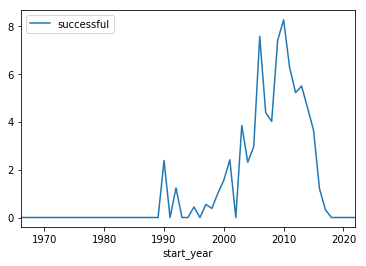

In [434]:
(df1.groupby('start_year')[['successful']].mean()*100).plot()

In [475]:
n1 = 12416
n2 = 2041

n1 + n2 -2

14455

In [482]:
p1 = 0.797
p2 = 0.697
q1 = 1-p1
q2 = 1-p2

(p1 - p2)/math.sqrt((p1*q1/n1) + (p2*q2/n2))

9.264617328216238

In [486]:
math.sqrt(1/n1 + 1/n2)

0.02388508197771247

In [20]:
df['start_date'].sort_values()

49068   1966-07-01
44063   1971-04-01
49206   1972-06-01
49042   1973-01-01
49056   1975-01-01
4289    1975-06-01
49069   1976-01-23
5137    1976-02-01
30585   1976-03-01
43865   1976-03-03
49118   1976-06-01
49119   1976-06-01
50992   1976-06-01
46249   1976-11-23
49053   1977-01-01
49133   1977-03-21
49054   1977-05-23
43866   1977-05-31
23920   1977-07-01
49125   1977-09-01
54314   1977-09-01
33042   1977-10-01
37114   1978-01-01
49315   1978-01-01
7734    1978-01-01
62650   1978-07-01
13779   1978-07-01
49143   1978-07-01
61679   1978-08-01
55580   1978-09-01
           ...    
49006          NaT
49007          NaT
49008          NaT
49009          NaT
49010          NaT
49011          NaT
49012          NaT
49013          NaT
49014          NaT
49015          NaT
49016          NaT
49017          NaT
49018          NaT
49019          NaT
49020          NaT
49021          NaT
49022          NaT
49023          NaT
49024          NaT
49025          NaT
49026          NaT
49027       